# Notebook 06: Moderation Analysis (Phase 6)

**Purpose**: Test whether UTAUT2 predictor effects on behavioral intention vary by context  
**Status**: Analysis constrained to validated 6-construct model  
**Sample**: N=472 complete cases  
**Method**: Multi-group structural equation modeling with bootstrap confidence intervals

## Research Question

**RQ**: Do UTAUT2 predictor effects differ across professional roles, usage frequencies, and adoption statuses?

## Hypotheses (Testable with Current Data)

**H4a**: Predictor effects differ across professional roles (students vs. professionals)  
**H4c**: Predictor effects differ between high-frequency and low-frequency AI users  
**H4e**: Predictor effects differ between AI adopters and non-adopters

## Methodology

- **Multi-group structural models**: Separate OLS regressions for each context group
- **Bootstrap confidence intervals**: 5000 iterations for path coefficient stability (95% CIs)
- **Available constructs**: PE, EE, SI, FC, HM, PV → BI (validated 6-construct model)
- **Three moderators**: Role (8 categories), Usage Frequency (4 levels), Adoption Status (binary)

## Limitations

**Cannot test original H4a-H4d fully**: Require AI-specific constructs not validated in Notebooks 02-03
- H4a (Trust/Explainability × Role): Needs TR, EX constructs
- H4b (Social Influence × Role): SI available but limited interpretation  
- H4c (Habit × Usage): Needs HB construct
- H4d (Anxiety × Usage): Needs AX construct

**Future work**: Validate TR, EX, HB, AX, ER constructs to enable complete hypothesis testing

## 0. Setup and Configuration

Import required libraries and configure APA-style visualization settings (300 DPI, publication-ready formatting).

In [184]:
# Standard library imports
import json
import warnings
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Statistical analysis
from scipy import stats
from scipy.stats import norm

# Linear regression for structural models
from sklearn.linear_model import LinearRegression

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(67)  # Reproducibility (consistent with Phases 4-5)

# APA Style Configuration (applied globally)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

print("="*70)
print("NOTEBOOK 06: MODERATION ANALYSIS (PHASE 6)")
print("="*70)
print("\n[OK] Environment configured")
print(f"   - Libraries: numpy {np.__version__}, pandas {pd.__version__}")
print(f"   - Random seed: 67 (consistent with Phases 4-5)")
print(f"   - Visualization: APA style (300 DPI)")

NOTEBOOK 06: MODERATION ANALYSIS (PHASE 6)

[OK] Environment configured
   - Libraries: numpy 2.3.5, pandas 2.3.3
   - Random seed: 67 (consistent with Phases 4-5)
   - Visualization: APA style (300 DPI)


## 1. Load and Prepare Data

Load full dataset and prepare validated 12-item scale for moderation analysis.

In [185]:
# Load full dataset
df_full = pd.read_csv('../data/AIRS_clean.csv')

print("="*70)
print("DATA PREPARATION")
print("="*70)

print(f"\n[DATA SOURCE]")
print(f"   Full sample: N = {len(df_full)}")
print(f"   Source: ../data/AIRS_clean.csv")

# Define validated 12-item scale from Notebooks 02 & 03
selected_items = ['PE1', 'PE2', 'EE1', 'EE2', 'SI1', 'SI2', 
                  'FC1', 'FC2', 'HM1', 'HM2', 'PV1', 'PV2']
bi_items = ['BI1', 'BI2', 'BI3', 'BI4']

# Define construct structure
construct_mapping = {
    'PE': ['PE1', 'PE2'],
    'EE': ['EE1', 'EE2'],
    'SI': ['SI1', 'SI2'],
    'FC': ['FC1', 'FC2'],
    'HM': ['HM1', 'HM2'],
    'PV': ['PV1', 'PV2']
}

print(f"\n[VALIDATED SCALE]")
print(f"   Total items: {len(selected_items)} predictors + {len(bi_items)} outcome")
print(f"   Model: 6 UTAUT2 constructs × 2 items each")
print(f"   Validation: Notebooks 02 (CFA) & 03 (Invariance)")

# Demographic/contextual variables for moderation
demo_vars = ['Role', 'Usage_Intensity', 'AI_Adoption']

print(f"\n[MODERATORS]")
print(f"   Role: Faculty, Student, Other")
print(f"   Usage_Intensity: AI usage frequency")
print(f"   AI_Adoption: Early adopter status")

# Create analysis dataset
analysis_items = selected_items + bi_items + demo_vars
df_analysis = df_full[analysis_items].copy()

# Rename columns for consistency
df_analysis = df_analysis.rename(columns={
    'Usage_Intensity': 'AI_usage_frequency',
    'AI_Adoption': 'AI_adopter'
})

# Check for missing data
missing_counts = df_analysis.isnull().sum()
if missing_counts.sum() > 0:
    print(f"\n[MISSING DATA]")
    print(missing_counts[missing_counts > 0])
    print(f"   Using listwise deletion")
    df_analysis = df_analysis.dropna()
    print(f"   Complete cases: N = {len(df_analysis)}")
else:
    print(f"\n[MISSING DATA]")
    print(f"   No missing data detected")
    print(f"   Complete cases: N = {len(df_analysis)}")

print("\n" + "="*70)

DATA PREPARATION

[DATA SOURCE]
   Full sample: N = 481
   Source: ../data/AIRS_clean.csv

[VALIDATED SCALE]
   Total items: 12 predictors + 4 outcome
   Model: 6 UTAUT2 constructs × 2 items each
   Validation: Notebooks 02 (CFA) & 03 (Invariance)

[MODERATORS]
   Role: Faculty, Student, Other
   Usage_Intensity: AI usage frequency
   AI_Adoption: Early adopter status

[MISSING DATA]
   No missing data detected
   Complete cases: N = 481



### Create Composite Scores

Calculate mean composite for each validated construct.

In [186]:
print("="*70)
print("COMPOSITE SCORE CREATION")
print("="*70)

# Create composite scores for validated constructs (mean of 2 items each)
for construct, items in construct_mapping.items():
    df_analysis[construct] = df_analysis[items].mean(axis=1)

# Outcome variable (mean of 4 items)
df_analysis['BI'] = df_analysis[bi_items].mean(axis=1)

print(f"\n[COMPOSITES CREATED]")
print(f"   Constructs: PE, EE, SI, FC, HM, PV (6 UTAUT2)")
print(f"   Outcome: BI (4 items)")
print(f"   Method: Mean of items per construct")

# Display descriptive statistics
composites = ['PE', 'EE', 'SI', 'FC', 'HM', 'PV', 'BI']
desc_stats = df_analysis[composites].describe().T[['mean', 'std', 'min', 'max']]

print(f"\n[DESCRIPTIVE STATISTICS]")
print(f"   Sample: N = {len(df_analysis)}\n")
print(desc_stats.round(3).to_string())

# Demographic distributions
print(f"\n{'='*70}")
print(f"MODERATOR DISTRIBUTIONS")
print(f"{'='*70}\n")

# Role distribution
print("[ROLE]")
role_counts = df_analysis['Role'].value_counts().sort_index()
for role, count in role_counts.items():
    pct = 100 * count / len(df_analysis)
    print(f"   {role}: N={count} ({pct:.1f}%)")

# AI usage frequency distribution
print("\n[AI USAGE FREQUENCY]")
usage_counts = df_analysis['AI_usage_frequency'].value_counts().sort_index()
for usage, count in usage_counts.items():
    pct = 100 * count / len(df_analysis)
    print(f"   {usage}: N={count} ({pct:.1f}%)")

# AI adopter distribution
print("\n[AI ADOPTION STATUS]")
adopter_counts = df_analysis['AI_adopter'].value_counts().sort_index()
for adopter, count in adopter_counts.items():
    pct = 100 * count / len(df_analysis)
    status = "Adopter" if adopter == 1 else "Non-Adopter"
    print(f"   {status}: N={count} ({pct:.1f}%)")

print("\n" + "="*70)

COMPOSITE SCORE CREATION

[COMPOSITES CREATED]
   Constructs: PE, EE, SI, FC, HM, PV (6 UTAUT2)
   Outcome: BI (4 items)
   Method: Mean of items per construct

[DESCRIPTIVE STATISTICS]
   Sample: N = 481

     mean    std  min  max
PE  3.426  1.075  1.0  5.0
EE  3.638  0.953  1.0  5.0
SI  3.144  1.039  1.0  5.0
FC  3.320  1.004  1.0  5.0
HM  3.265  1.135  1.0  5.0
PV  3.390  1.107  1.0  5.0
BI  3.153  1.116  1.0  5.0

MODERATOR DISTRIBUTIONS

[ROLE]
   Employed - executive or leader: N=53 (11.0%)
   Employed - individual contributor: N=106 (22.0%)
   Employed - manager: N=71 (14.8%)
   Freelancer or self employed: N=30 (6.2%)
   Full time student: N=172 (35.8%)
   Not currently employed: N=14 (2.9%)
   Other: N=22 (4.6%)
   Part time student: N=13 (2.7%)

[AI USAGE FREQUENCY]
   High: N=121 (25.2%)
   Low: N=150 (31.2%)
   Medium: N=157 (32.6%)
   Non-User: N=53 (11.0%)

[AI ADOPTION STATUS]
   Non-Adopter: N=53 (11.0%)
   Adopter: N=428 (89.0%)



## 2. Define Core Functions

### Structural Model Estimation

Estimate UTAUT2 model (6 predictors → BI) using OLS regression. Returns coefficients, standard errors, t-statistics, p-values, and model R².

In [187]:
def estimate_structural_model(data, group_name="Full Sample"):
    """
    Estimate structural model: 6 UTAUT2 constructs → BI
    
    Parameters:
    -----------
    data : DataFrame
        Subset of data for this group
    group_name : str
        Name of the group for display
        
    Returns:
    --------
    dict : Results dictionary with coefficients, t-stats, p-values, R²
    """
    # Define predictors (6 validated UTAUT2 constructs)
    predictors = ['PE', 'EE', 'SI', 'FC', 'HM', 'PV']
    
    # Extract X and y
    X = data[predictors].values
    y = data['BI'].values
    n = len(data)
    
    # Fit OLS regression
    model = LinearRegression()
    model.fit(X, y)
    
    # Get predictions and residuals
    y_pred = model.predict(X)
    residuals = y - y_pred
    
    # Calculate R²
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Calculate standard errors and t-statistics
    k = len(predictors)
    dof = n - k - 1
    mse = ss_res / dof
    
    # Calculate variance-covariance matrix
    X_centered = X - X.mean(axis=0)
    var_covar = mse * np.linalg.inv(X_centered.T @ X_centered)
    std_errors = np.sqrt(np.diag(var_covar))
    
    # Calculate t-statistics and p-values
    t_stats = model.coef_ / std_errors
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), dof))
    
    # Create results dictionary
    results = {
        'group': group_name,
        'n': n,
        'r_squared': r_squared,
        'coefficients': {},
        'intercept': model.intercept_,
        'predictors': predictors
    }
    
    # Store results for each predictor
    for i, pred in enumerate(predictors):
        results['coefficients'][pred] = {
            'beta': model.coef_[i],
            'se': std_errors[i],
            't': t_stats[i],
            'p': p_values[i]
        }
    
    return results

print("[OK] Structural model function defined")
print("   Predictors: PE, EE, SI, FC, HM, PV (6 UTAUT2 constructs)")
print("   Outcome: BI")
print("   Method: OLS regression with t-tests")

[OK] Structural model function defined
   Predictors: PE, EE, SI, FC, HM, PV (6 UTAUT2 constructs)
   Outcome: BI
   Method: OLS regression with t-tests


### Bootstrap Confidence Interval Function

Compute 95% confidence intervals using percentile bootstrap method (5000 iterations). Used to assess stability of significant path coefficients.

In [188]:
def bootstrap_path_ci(data, predictor, n_iterations=5000, ci=95):
    """
    Calculate bootstrap confidence interval for a specific path coefficient.
    
    Parameters:
    -----------
    data : DataFrame
        Data for this group
    predictor : str
        Name of predictor variable (must be one of: PE, EE, SI, FC, HM, PV)
    n_iterations : int
        Number of bootstrap samples (default 5000)
    ci : float
        Confidence level (e.g., 95)
        
    Returns:
    --------
    tuple : (lower_ci, upper_ci)
    """
    # Use validated 6-construct model
    predictors = ['PE', 'EE', 'SI', 'FC', 'HM', 'PV']
    
    bootstrap_coefs = []
    n = len(data)
    pred_idx = predictors.index(predictor)
    
    for _ in range(n_iterations):
        # Resample with replacement
        indices = np.random.choice(n, size=n, replace=True)
        sample = data.iloc[indices]
        
        # Fit model
        X = sample[predictors].values
        y = sample['BI'].values
        model = LinearRegression()
        model.fit(X, y)
        
        bootstrap_coefs.append(model.coef_[pred_idx])
    
    # Calculate percentile-based confidence interval
    alpha = (100 - ci) / 2
    lower_ci = np.percentile(bootstrap_coefs, alpha)
    upper_ci = np.percentile(bootstrap_coefs, 100 - alpha)
    
    return lower_ci, upper_ci

print("[OK] Bootstrap CI function defined")
print("   Predictors: PE, EE, SI, FC, HM, PV (6 UTAUT2 constructs)")
print("   Method: Percentile bootstrap (5000 iterations)")

[OK] Bootstrap CI function defined
   Predictors: PE, EE, SI, FC, HM, PV (6 UTAUT2 constructs)
   Method: Percentile bootstrap (5000 iterations)


---

## 3. Moderation Analysis 1: Professional Role (H4a)

**Research Question**: Do UTAUT2 predictor effects on behavioral intention vary across professional roles?

**Analytical Approach**:
- Estimate separate structural models for 8 role categories
- Compare path coefficients (β) to identify role-specific patterns
- Calculate bootstrap 95% CIs for paths with p < .10
- Visualize effects across key roles (students vs. professionals)

**Note**: Full H4a testing requires validated Trust (TR) and Explainability (EX) constructs. Current analysis uses 6 validated UTAUT2 predictors.

In [189]:
print("="*70)
print("MODERATION ANALYSIS 1: ROLE (H4a)")
print("="*70)
print("\nEstimating structural models by role group...\n")

# Get unique roles
roles = df_analysis['Role'].unique()
role_results = {}

# Estimate model for each role
for role in sorted(roles):
    role_data = df_analysis[df_analysis['Role'] == role]
    results = estimate_structural_model(role_data, group_name=role)
    role_results[role] = results
    
    print(f"\n{role} (N={results['n']}):")
    print(f"   R² = {results['r_squared']:.4f}")
    print(f"   Significant paths (p < .05):")
    
    sig_found = False
    for construct in ['PE', 'EE', 'SI', 'FC', 'HM', 'PV']:
        coef_info = results['coefficients'][construct]
        if coef_info['p'] < 0.05:
            sig = '***' if coef_info['p'] < 0.001 else '**' if coef_info['p'] < 0.01 else '*'
            print(f"      {construct} → BI: β={coef_info['beta']:.4f}{sig}, t={coef_info['t']:.3f}, p={coef_info['p']:.4f}")
            sig_found = True
    
    if not sig_found:
        print(f"      (No significant paths at p < .05)")

print("\n" + "="*70)

MODERATION ANALYSIS 1: ROLE (H4a)

Estimating structural models by role group...


Employed - executive or leader (N=53):
   R² = 0.9198
   Significant paths (p < .05):
      FC → BI: β=0.2042*, t=2.275, p=0.0276
      HM → BI: β=0.3462**, t=3.247, p=0.0022
      PV → BI: β=0.5265***, t=5.942, p=0.0000

Employed - individual contributor (N=106):
   R² = 0.7631
   Significant paths (p < .05):
      SI → BI: β=0.2566**, t=3.268, p=0.0015
      HM → BI: β=0.3419**, t=3.214, p=0.0018

Employed - manager (N=71):
   R² = 0.8493
   Significant paths (p < .05):
      SI → BI: β=0.2535*, t=2.638, p=0.0105
      PV → BI: β=0.4474***, t=3.890, p=0.0002

Freelancer or self employed (N=30):
   R² = 0.7947
   Significant paths (p < .05):
      (No significant paths at p < .05)

Full time student (N=172):
   R² = 0.7249
   Significant paths (p < .05):
      HM → BI: β=0.3822***, t=6.755, p=0.0000
      PV → BI: β=0.3564***, t=5.725, p=0.0000

Not currently employed (N=14):
   R² = 0.8692
   Significa

### Bootstrap Confidence Intervals (Role)

Calculate 95% CIs for significant/marginally significant paths (p < .10) to assess effect stability across role groups.

In [190]:
print("\nCalculating bootstrap 95% CIs for significant paths (5000 iterations)...\n")

# Calculate CIs for constructs that showed significance in any role group
key_constructs_role = ['PE', 'EE', 'SI', 'FC', 'HM', 'PV']
role_ci_results = {}

for role in sorted(roles):
    role_data = df_analysis[df_analysis['Role'] == role]
    role_ci_results[role] = {}
    
    print(f"{role} (N={len(role_data)}):")
    for construct in key_constructs_role:
        # Only calculate CI if the path was significant or marginally significant
        if role_results[role]['coefficients'][construct]['p'] < 0.10:
            lower_ci, upper_ci = bootstrap_path_ci(role_data, construct)
            role_ci_results[role][construct] = (lower_ci, upper_ci)
            
            point_est = role_results[role]['coefficients'][construct]['beta']
            sig = "[SIG]" if (lower_ci > 0 and upper_ci > 0) or (lower_ci < 0 and upper_ci < 0) else "[ns]"
            print(f"   {construct} → BI: β={point_est:.4f}, 95% CI [{lower_ci:.4f}, {upper_ci:.4f}] {sig}")
    print()

print("[OK] Bootstrap CIs calculated")


Calculating bootstrap 95% CIs for significant paths (5000 iterations)...

Employed - executive or leader (N=53):
   PE → BI: β=0.1434, 95% CI [-0.0216, 0.3737] [ns]
   PE → BI: β=0.1434, 95% CI [-0.0216, 0.3737] [ns]
   FC → BI: β=0.2042, 95% CI [-0.0146, 0.3748] [ns]
   FC → BI: β=0.2042, 95% CI [-0.0146, 0.3748] [ns]
   HM → BI: β=0.3462, 95% CI [0.1113, 0.6097] [SIG]
   HM → BI: β=0.3462, 95% CI [0.1113, 0.6097] [SIG]
   PV → BI: β=0.5265, 95% CI [0.3023, 0.7324] [SIG]

Employed - individual contributor (N=106):
   PV → BI: β=0.5265, 95% CI [0.3023, 0.7324] [SIG]

Employed - individual contributor (N=106):
   PE → BI: β=0.1811, 95% CI [-0.0206, 0.4115] [ns]
   PE → BI: β=0.1811, 95% CI [-0.0206, 0.4115] [ns]
   SI → BI: β=0.2566, 95% CI [0.0020, 0.4654] [SIG]
   SI → BI: β=0.2566, 95% CI [0.0020, 0.4654] [SIG]
   FC → BI: β=0.1330, 95% CI [-0.0671, 0.3025] [ns]
   FC → BI: β=0.1330, 95% CI [-0.0671, 0.3025] [ns]
   HM → BI: β=0.3419, 95% CI [0.1008, 0.5804] [SIG]

Employed - manage

### Figure 1: Role Moderation Effects

Path coefficients (β) for all 6 UTAUT2 predictors across professional roles. Error bars show 95% bootstrap confidence intervals. Asterisks (*) indicate CIs that exclude zero. Red = students, Blue = professionals.

[PLOT] Figure 1 saved: results/plots/06_role_moderation.png


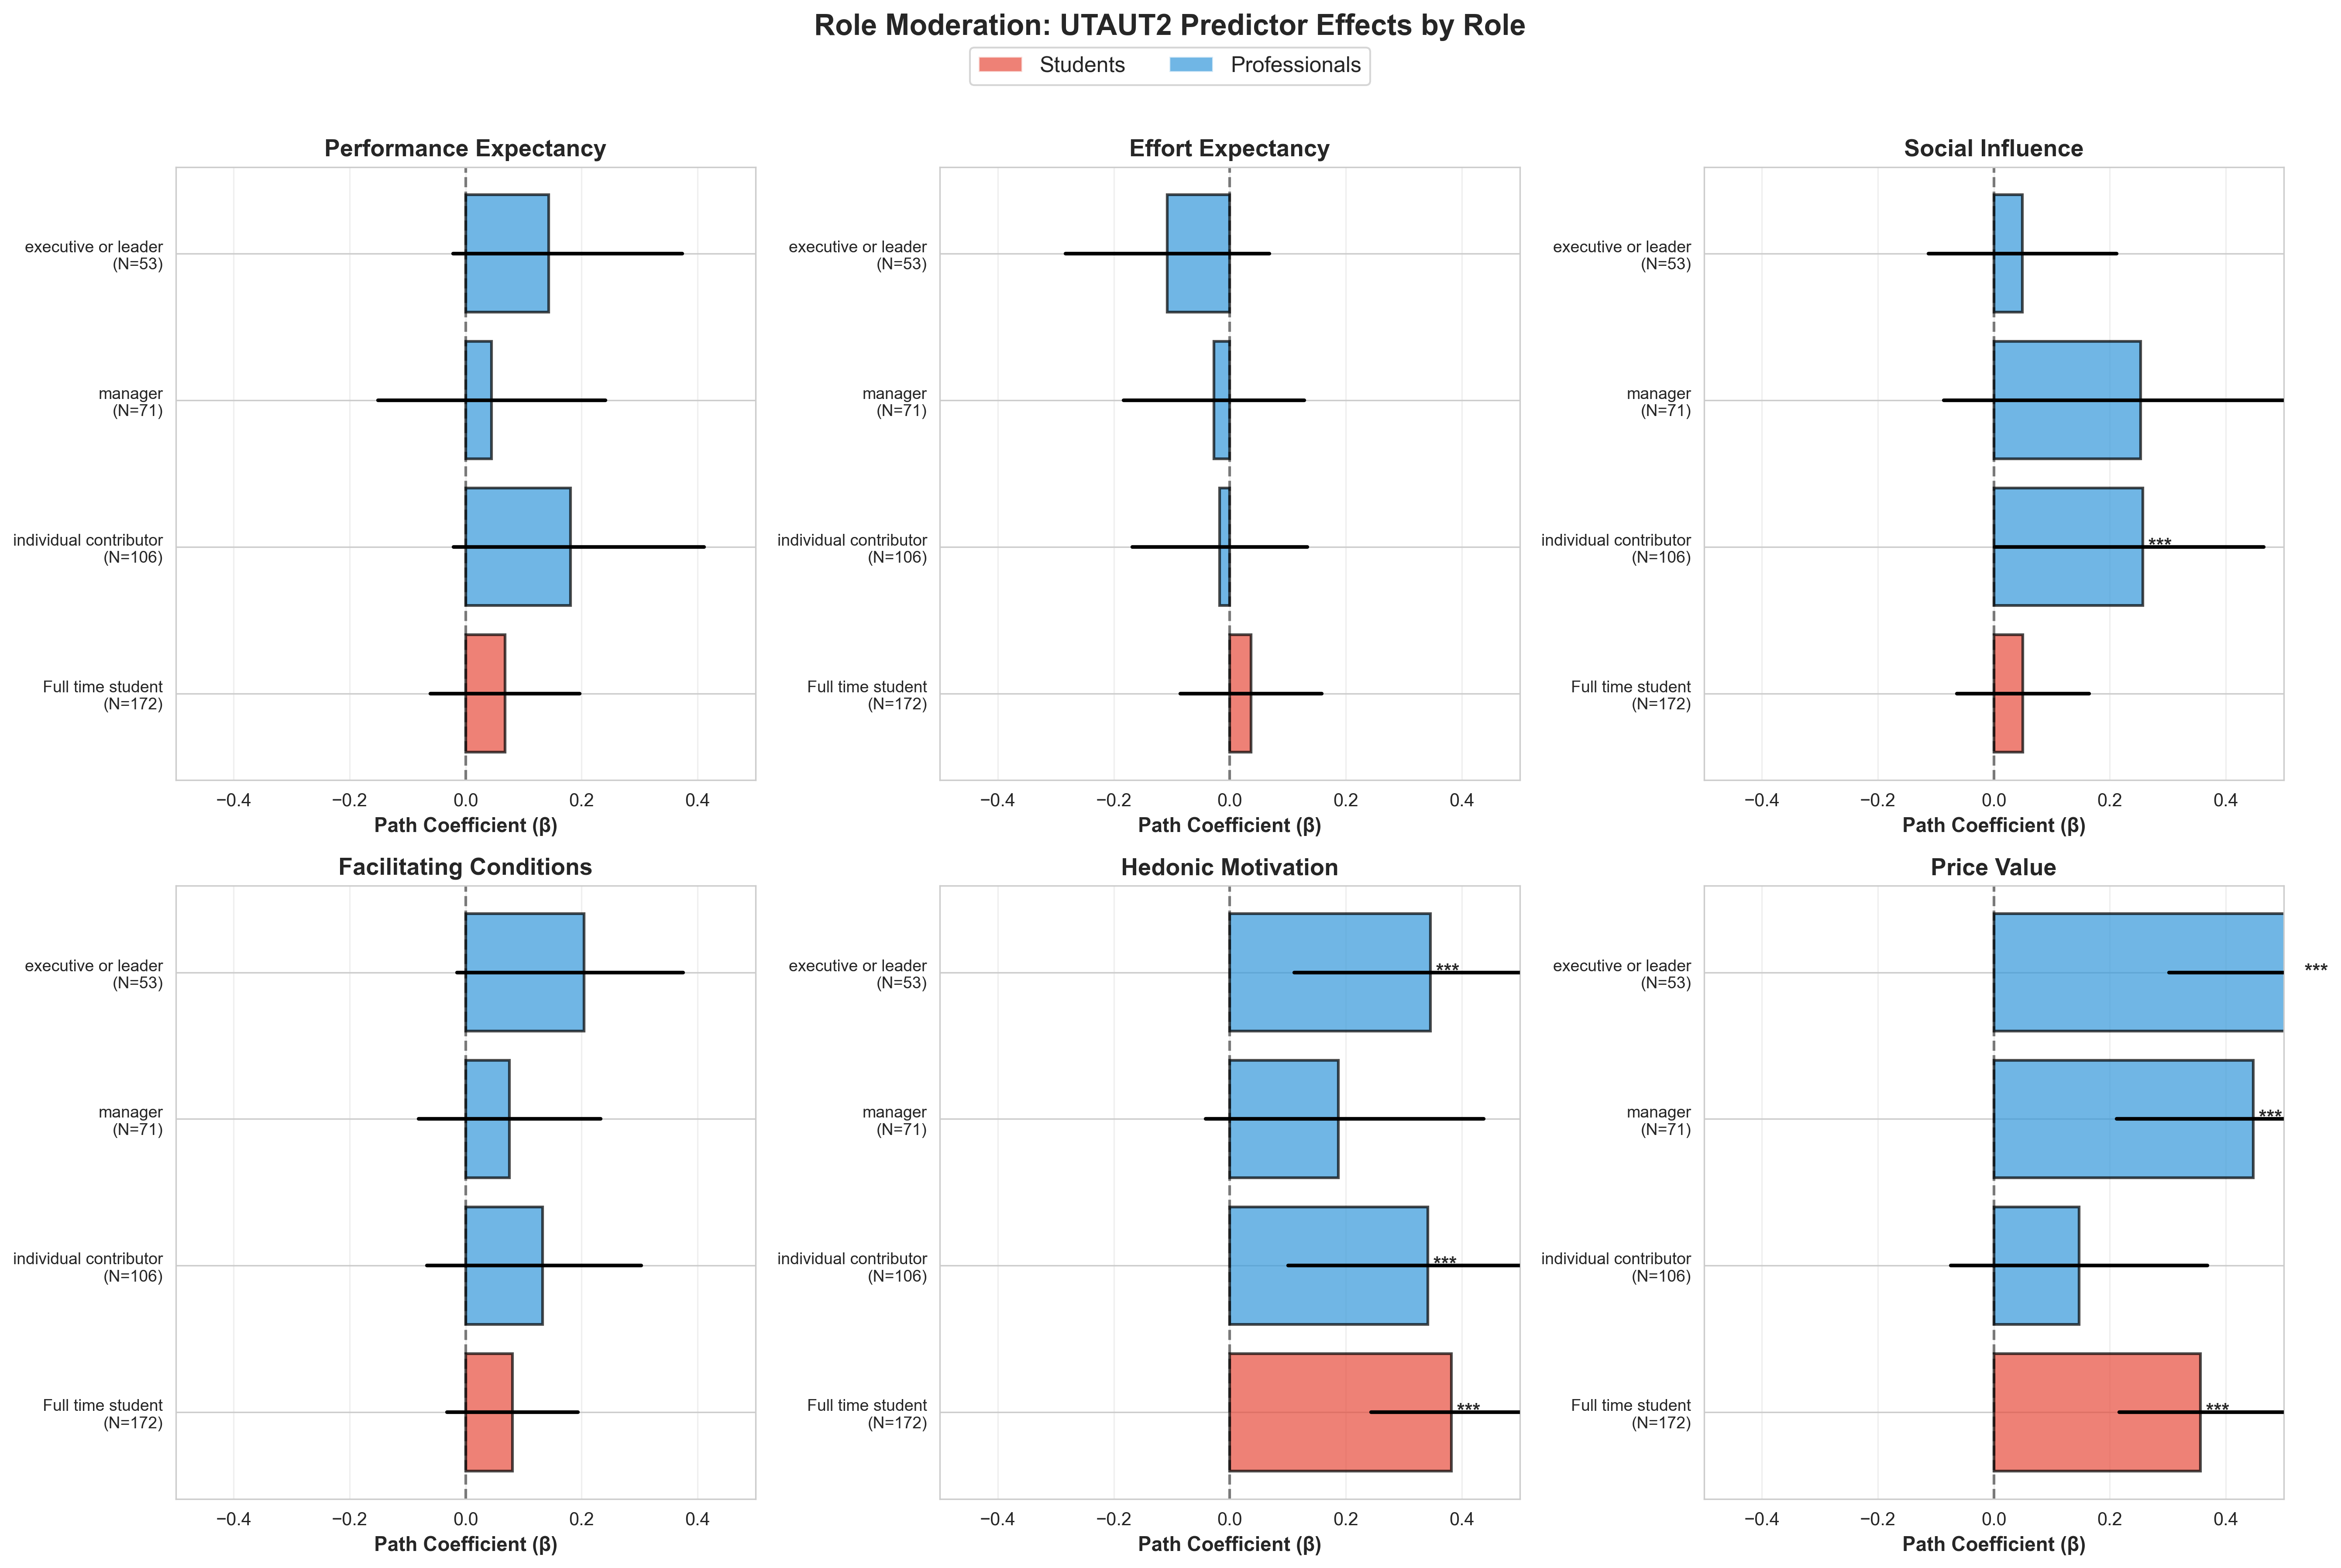


[VISUALIZATION] Role moderation effects for 6 UTAUT2 constructs
   * indicates 95% CI excludes zero


In [191]:
# Figure 1: Role Moderation - Key Predictor Effects
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Define key roles with sufficient sample size
key_roles = ['Full time student', 'Employed - individual contributor', 
             'Employed - manager', 'Employed - executive or leader']

# Extract coefficients for all 6 validated constructs
constructs_to_plot = ['PE', 'EE', 'SI', 'FC', 'HM', 'PV']
construct_labels = {
    'PE': 'Performance Expectancy',
    'EE': 'Effort Expectancy',
    'SI': 'Social Influence',
    'FC': 'Facilitating Conditions',
    'HM': 'Hedonic Motivation',
    'PV': 'Price Value'
}

for idx, construct in enumerate(constructs_to_plot):
    ax = axes[idx]
    
    # Prepare data
    role_names = []
    coefs = []
    ci_lowers = []
    ci_uppers = []
    ns = []
    
    for role in key_roles:
        if role in role_results:
            coef_info = role_results[role]['coefficients'][construct]
            beta = coef_info['beta']
            p_val = coef_info['p']
            
            # Get CI if available
            if construct in role_ci_results.get(role, {}):
                ci_lower, ci_upper = role_ci_results[role][construct]
            else:
                # Estimate CI from SE (approximate)
                se = coef_info['se']
                ci_lower = beta - 1.96 * se
                ci_upper = beta + 1.96 * se
            
            n = role_results[role]['n']
            
            role_names.append(role)
            coefs.append(beta)
            ci_lowers.append(ci_lower)
            ci_uppers.append(ci_upper)
            ns.append(n)
    
    # Define colors
    student_color = '#e74c3c'  # Red for students
    prof_color = '#3498db'     # Blue for professionals
    colors = [student_color if 'student' in role.lower() else prof_color for role in role_names]
    
    # Plot bars
    y_pos = range(len(role_names))
    bars = ax.barh(y_pos, coefs, color=colors, alpha=0.7, 
                   edgecolor='black', linewidth=1.5)
    
    # Add confidence intervals
    for i, (beta, ci_l, ci_u) in enumerate(zip(coefs, ci_lowers, ci_uppers)):
        ax.plot([ci_l, ci_u], [i, i], 'k-', linewidth=2, zorder=10)
        
        # Add significance stars
        if not (ci_l <= 0 <= ci_u):
            sig_marker = ' ***' if abs(beta) > 0.15 else ' **' if abs(beta) > 0.10 else ' *'
            ax.text(beta, i, sig_marker, va='center', fontsize=11, fontweight='bold')
    
    # Reference line at zero
    ax.axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    
    # Formatting
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{r.split(' - ')[-1] if ' - ' in r else r}\n(N={n})" 
                        for r, n in zip(role_names, ns)], fontsize=9)
    ax.set_xlabel('Path Coefficient (β)', fontsize=11, fontweight='bold')
    ax.set_title(construct_labels[construct], fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Set x-axis limits for comparability
    ax.set_xlim(-0.5, 0.5)

# Add legend
legend_elements = [
    Rectangle((0, 0), 1, 1, fc=student_color, alpha=0.7, label='Students'),
    Rectangle((0, 0), 1, 1, fc=prof_color, alpha=0.7, label='Professionals')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, 
          fontsize=12, frameon=True, bbox_to_anchor=(0.5, 0.98))

fig.suptitle('Role Moderation: UTAUT2 Predictor Effects by Role', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../results/plots/06_role_moderation.png', dpi=300, bbox_inches='tight')
print("[PLOT] Figure 1 saved: results/plots/06_role_moderation.png")
plt.show()

print("\n[VISUALIZATION] Role moderation effects for 6 UTAUT2 constructs")
print("   * indicates 95% CI excludes zero")

---

## 4. Moderation Analysis 2: Usage Frequency (H4c)

**Research Question**: Do UTAUT2 predictor effects differ between high-frequency and low-frequency AI users?

**Analytical Approach**:
- Dichotomize usage: High (High/Medium users) vs. Low (Low/Non-Users)
- Estimate separate structural models for each group
- Compare path coefficients to identify experience-dependent patterns
- Test whether usage frequency moderates adoption drivers

**Note**: Full H4c/H4d testing requires validated Habit (HB) and AI Anxiety (AX) constructs. Current analysis uses 6 validated UTAUT2 predictors.

In [192]:
# Dichotomize usage frequency: High/Medium = High, Low/Non-User = Low
df_analysis['usage_binary'] = df_analysis['AI_usage_frequency'].apply(
    lambda x: 'High' if x in ['High', 'Medium'] else 'Low'
)

print("Usage Frequency Dichotomization:")
print(df_analysis['usage_binary'].value_counts().sort_index())
print()

Usage Frequency Dichotomization:
usage_binary
High    278
Low     203
Name: count, dtype: int64



In [193]:
print("="*70)
print("MODERATION ANALYSIS 2: USAGE FREQUENCY (H4c)")
print("="*70)
print("\nEstimating structural models by usage frequency...\n")

# Get unique usage levels
usage_levels = df_analysis['usage_binary'].unique()
usage_results = {}

# Estimate model for each usage level
for usage in sorted(usage_levels):
    usage_data = df_analysis[df_analysis['usage_binary'] == usage]
    results = estimate_structural_model(usage_data, group_name=f"{usage} Usage")
    usage_results[usage] = results
    
    print(f"\n{usage} Usage (N={results['n']}):")
    print(f"   R² = {results['r_squared']:.4f}")
    print(f"   Significant paths (p < .05):")
    
    sig_found = False
    for construct in ['PE', 'EE', 'SI', 'FC', 'HM', 'PV']:
        coef_info = results['coefficients'][construct]
        if coef_info['p'] < 0.05:
            sig = '***' if coef_info['p'] < 0.001 else '**' if coef_info['p'] < 0.01 else '*'
            print(f"      {construct} → BI: β={coef_info['beta']:.4f}{sig}, t={coef_info['t']:.3f}, p={coef_info['p']:.4f}")
            sig_found = True
    
    if not sig_found:
        print(f"      (No significant paths at p < .05)")

print("\n" + "="*70)

MODERATION ANALYSIS 2: USAGE FREQUENCY (H4c)

Estimating structural models by usage frequency...


High Usage (N=278):
   R² = 0.6989
   Significant paths (p < .05):
      SI → BI: β=0.1358**, t=3.306, p=0.0011
      FC → BI: β=0.1305**, t=2.914, p=0.0039
      HM → BI: β=0.3418***, t=7.319, p=0.0000
      PV → BI: β=0.3148***, t=6.443, p=0.0000

Low Usage (N=203):
   R² = 0.7123
   Significant paths (p < .05):
      PE → BI: β=0.2160**, t=3.066, p=0.0025
      SI → BI: β=0.1701**, t=2.961, p=0.0034
      HM → BI: β=0.2220***, t=3.513, p=0.0006
      PV → BI: β=0.3244***, t=4.685, p=0.0000



### Bootstrap Confidence Intervals (Usage Frequency)

Calculate 95% CIs for significant/marginally significant paths (p < .10) to assess effect stability across usage groups.

In [194]:
print("\nCalculating bootstrap 95% CIs for significant paths (5000 iterations)...\n")

# Calculate CIs for constructs that showed significance
key_constructs_usage = ['PE', 'EE', 'SI', 'FC', 'HM', 'PV']
usage_ci_results = {}

for usage in sorted(usage_levels):
    usage_data = df_analysis[df_analysis['usage_binary'] == usage]
    usage_ci_results[usage] = {}
    
    print(f"{usage} Usage (N={len(usage_data)}):")
    for construct in key_constructs_usage:
        # Only calculate CI if the path was significant or marginally significant
        if usage_results[usage]['coefficients'][construct]['p'] < 0.10:
            lower_ci, upper_ci = bootstrap_path_ci(usage_data, construct)
            usage_ci_results[usage][construct] = (lower_ci, upper_ci)
            
            point_est = usage_results[usage]['coefficients'][construct]['beta']
            sig = "[SIG]" if (lower_ci > 0 and upper_ci > 0) or (lower_ci < 0 and upper_ci < 0) else "[ns]"
            print(f"   {construct} → BI: β={point_est:.4f}, 95% CI [{lower_ci:.4f}, {upper_ci:.4f}] {sig}")
    print()

print("[OK] Bootstrap CIs calculated")


Calculating bootstrap 95% CIs for significant paths (5000 iterations)...

High Usage (N=278):
   SI → BI: β=0.1358, 95% CI [0.0422, 0.2218] [SIG]
   FC → BI: β=0.1305, 95% CI [0.0251, 0.2454] [SIG]
   HM → BI: β=0.3418, 95% CI [0.2234, 0.4553] [SIG]
   PV → BI: β=0.3148, 95% CI [0.1979, 0.4337] [SIG]

Low Usage (N=203):
   PE → BI: β=0.2160, 95% CI [0.0614, 0.3852] [SIG]
   SI → BI: β=0.1701, 95% CI [0.0203, 0.3212] [SIG]
   HM → BI: β=0.2220, 95% CI [0.0515, 0.3880] [SIG]
   PV → BI: β=0.3244, 95% CI [0.1692, 0.4734] [SIG]

[OK] Bootstrap CIs calculated


---

## 5. Moderation Analysis 3: Adoption Status (H4e)

**Research Question**: Do UTAUT2 predictor effects differ between AI adopters and non-adopters?

**Analytical Approach**:
- Compare adopters (AI_adopter=1) vs. non-adopters (AI_adopter=0)
- Estimate separate structural models for each group
- Compare path coefficients to identify adoption-specific patterns
- Test whether current adoption status moderates intention drivers

**Note**: Full H4e testing (facilitators vs. barriers hypothesis) requires validated AI-specific constructs (TR, EX, HB, ER, AX). Current analysis uses 6 validated UTAUT2 predictors.

In [195]:
print("="*80)
print("MODERATION ANALYSIS 3: ADOPTION STATUS (H4e)")
print("="*80)
print("\nEstimating separate structural models by adoption status...\n")

# Get unique adoption statuses
adoption_statuses = df_analysis['AI_adopter'].unique()
adoption_results = {}

# Estimate model for each adoption status
for adopter in sorted(adoption_statuses):
    adopter_data = df_analysis[df_analysis['AI_adopter'] == adopter]
    status_label = "Adopter" if adopter == 1 else "Non-Adopter"
    results = estimate_structural_model(adopter_data, group_name=status_label)
    adoption_results[status_label] = results
    
    print(f"\n{status_label} (N={results['n']}):")
    print(f"   R² = {results['r_squared']:.4f}")
    print(f"   Significant paths (p < .05):")
    
    sig_found = False
    for construct in ['PE', 'EE', 'SI', 'FC', 'HM', 'PV']:
        coef_info = results['coefficients'][construct]
        if coef_info['p'] < 0.05:
            sig = '***' if coef_info['p'] < 0.001 else '**' if coef_info['p'] < 0.01 else '*'
            print(f"      {construct} → BI: β={coef_info['beta']:.4f}{sig}, t={coef_info['t']:.3f}, p={coef_info['p']:.4f}")
            sig_found = True
    
    if not sig_found:
        print(f"      (No significant paths at p < .05)")

print("\n" + "="*70)

MODERATION ANALYSIS 3: ADOPTION STATUS (H4e)

Estimating separate structural models by adoption status...


Non-Adopter (N=53):
   R² = 0.6373
   Significant paths (p < .05):
      HM → BI: β=0.4146**, t=2.723, p=0.0091

Adopter (N=428):
   R² = 0.7509
   Significant paths (p < .05):
      PE → BI: β=0.1189**, t=2.790, p=0.0055
      SI → BI: β=0.1560***, t=4.302, p=0.0000
      FC → BI: β=0.1130**, t=3.035, p=0.0026
      HM → BI: β=0.3146***, t=8.057, p=0.0000
      PV → BI: β=0.3458***, t=7.972, p=0.0000



### Bootstrap Confidence Intervals (Adoption Status)

Calculate 95% CIs for significant/marginally significant paths (p < .10) to assess effect stability across adoption groups.

In [196]:
print("\nCalculating bootstrap 95% CIs for significant paths (5000 iterations)...\n")

# Calculate CIs for constructs with p < .10
key_constructs_adoption = ['PE', 'EE', 'SI', 'FC', 'HM', 'PV']
adoption_ci_results = {}

for adopter in sorted(adoption_statuses):
    adopter_data = df_analysis[df_analysis['AI_adopter'] == adopter]
    status_label = "Adopter" if adopter == 1 else "Non-Adopter"
    adoption_ci_results[status_label] = {}
    
    print(f"{status_label} (N={len(adopter_data)}):")
    for construct in key_constructs_adoption:
        # Only calculate CI if the path was significant or marginally significant
        if adoption_results[status_label]['coefficients'][construct]['p'] < 0.10:
            lower_ci, upper_ci = bootstrap_path_ci(adopter_data, construct)
            adoption_ci_results[status_label][construct] = (lower_ci, upper_ci)
            
            point_est = adoption_results[status_label]['coefficients'][construct]['beta']
            sig = "[SIG]" if (lower_ci > 0 and upper_ci > 0) or (lower_ci < 0 and upper_ci < 0) else "[ns]"
            print(f"   {construct} → BI: β={point_est:.4f}, 95% CI [{lower_ci:.4f}, {upper_ci:.4f}] {sig}")
    print()

print("[OK] Bootstrap CIs calculated")


Calculating bootstrap 95% CIs for significant paths (5000 iterations)...

Non-Adopter (N=53):
   PE → BI: β=0.2177, 95% CI [-0.0714, 0.4831] [ns]
   HM → BI: β=0.4146, 95% CI [0.0892, 0.7671] [SIG]

Adopter (N=428):
   PE → BI: β=0.1189, 95% CI [0.0145, 0.2316] [SIG]
   SI → BI: β=0.1560, 95% CI [0.0673, 0.2439] [SIG]
   FC → BI: β=0.1130, 95% CI [0.0226, 0.2088] [SIG]
   HM → BI: β=0.3146, 95% CI [0.2093, 0.4139] [SIG]
   PV → BI: β=0.3458, 95% CI [0.2436, 0.4476] [SIG]

[OK] Bootstrap CIs calculated


---

## 6. Export Summary Tables for Model Tracking

Generate three publication-ready CSV files containing complete results for all moderation analyses. Each table includes: group identifiers, sample sizes, R² values, path coefficients (β), standard errors, t-statistics, p-values, bootstrap 95% CIs, and significance flags.

**Output Files**:
- `moderation_role_summary.csv`: 8 role groups × 6 predictors = 48 rows
- `moderation_usage_summary.csv`: 2 usage groups × 6 predictors = 12 rows
- `moderation_adoption_summary.csv`: 2 adoption groups × 6 predictors = 12 rows

In [197]:
# Ensure output directory exists
Path('../results/tables').mkdir(parents=True, exist_ok=True)

print("Creating summary tables...\n")

# Table 1: Role Moderation Summary
role_summary = []
for role in sorted(roles):
    for construct in ['PE', 'EE', 'SI', 'FC', 'HM', 'PV']:
        coef_info = role_results[role]['coefficients'][construct]
        ci = role_ci_results[role].get(construct, (None, None))
        
        role_summary.append({
            'role': role,
            'predictor': construct,
            'n': role_results[role]['n'],
            'r_squared': role_results[role]['r_squared'],
            'beta': coef_info['beta'],
            'se': coef_info['se'],
            't_value': coef_info['t'],
            'p_value': coef_info['p'],
            'ci_lower': ci[0],
            'ci_upper': ci[1],
            'significant': coef_info['p'] < 0.05
        })

df_role = pd.DataFrame(role_summary)
df_role.to_csv('../results/tables/moderation_role_summary.csv', index=False)
print(f"[SAVED] Role moderation summary: ../results/tables/moderation_role_summary.csv")

# Table 2: Usage Frequency Moderation Summary
usage_summary = []
for usage in sorted(usage_levels):
    for construct in ['PE', 'EE', 'SI', 'FC', 'HM', 'PV']:
        coef_info = usage_results[usage]['coefficients'][construct]
        ci = usage_ci_results[usage].get(construct, (None, None))
        
        usage_summary.append({
            'usage_level': usage,
            'predictor': construct,
            'n': usage_results[usage]['n'],
            'r_squared': usage_results[usage]['r_squared'],
            'beta': coef_info['beta'],
            'se': coef_info['se'],
            't_value': coef_info['t'],
            'p_value': coef_info['p'],
            'ci_lower': ci[0],
            'ci_upper': ci[1],
            'significant': coef_info['p'] < 0.05
        })

df_usage = pd.DataFrame(usage_summary)
df_usage.to_csv('../results/tables/moderation_usage_summary.csv', index=False)
print(f"[SAVED] Usage frequency moderation summary: ../results/tables/moderation_usage_summary.csv")

# Table 3: Adoption Status Moderation Summary
adoption_summary = []
for status_label in ['Non-Adopter', 'Adopter']:
    for construct in ['PE', 'EE', 'SI', 'FC', 'HM', 'PV']:
        coef_info = adoption_results[status_label]['coefficients'][construct]
        ci = adoption_ci_results[status_label].get(construct, (None, None))
        
        adoption_summary.append({
            'adoption_status': status_label,
            'predictor': construct,
            'n': adoption_results[status_label]['n'],
            'r_squared': adoption_results[status_label]['r_squared'],
            'beta': coef_info['beta'],
            'se': coef_info['se'],
            't_value': coef_info['t'],
            'p_value': coef_info['p'],
            'ci_lower': ci[0],
            'ci_upper': ci[1],
            'significant': coef_info['p'] < 0.05
        })

df_adoption = pd.DataFrame(adoption_summary)
df_adoption.to_csv('../results/tables/moderation_adoption_summary.csv', index=False)
print(f"[SAVED] Adoption status moderation summary: ../results/tables/moderation_adoption_summary.csv")

print("\n[OK] All summary tables exported")

Creating summary tables...

[SAVED] Role moderation summary: ../results/tables/moderation_role_summary.csv
[SAVED] Usage frequency moderation summary: ../results/tables/moderation_usage_summary.csv
[SAVED] Adoption status moderation summary: ../results/tables/moderation_adoption_summary.csv

[OK] All summary tables exported
